Best hyperparameters from GridSearchCV:
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}


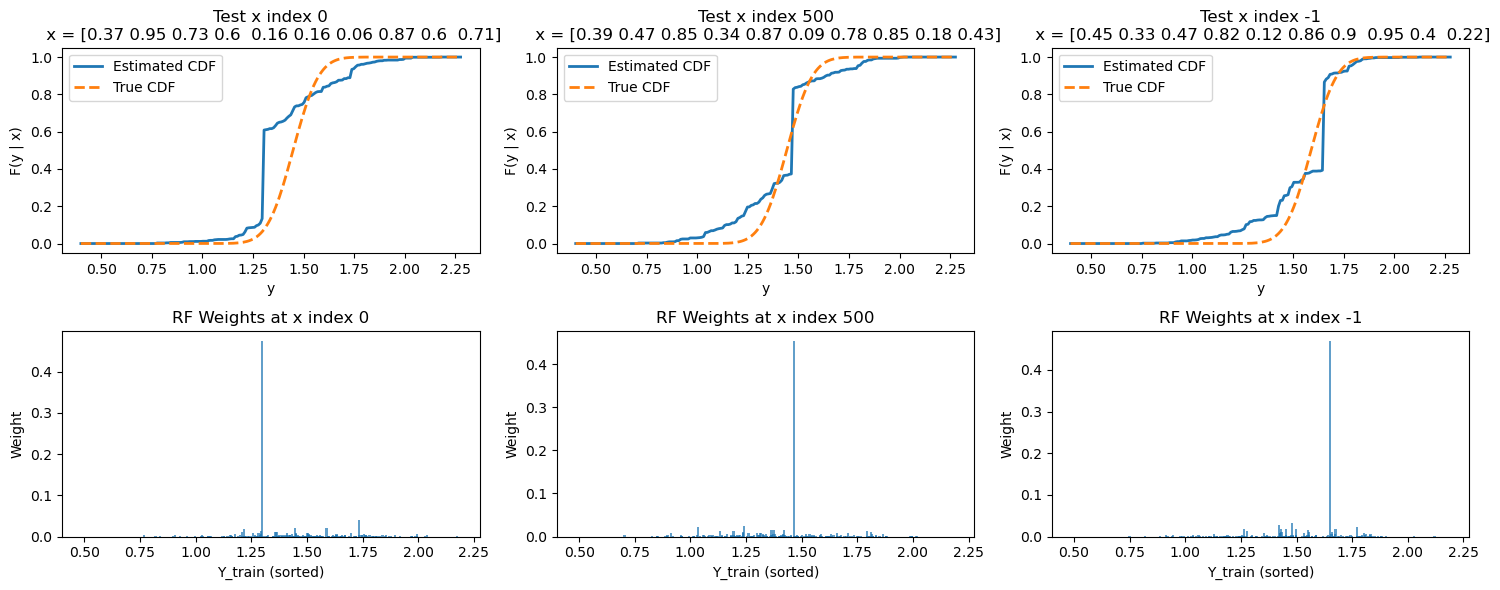

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# ----------------------------
# 1. Synthetic Data Generation
# ----------------------------
def generate_data(n_samples, d, sigma=0.1, random_state=42):
    np.random.seed(random_state)
    # Generate d-dimensional features uniformly over [0,1]
    X = np.random.uniform(0, 1, size=(n_samples, d))
    # Define beta as a fixed vector; for instance, beta = [1, 2, ..., d] normalized
    beta = np.arange(1, d + 1, dtype=float)
    beta /= np.linalg.norm(beta)  # normalize beta
    # Linear model: y = beta^T X + noise
    y = X.dot(beta) + np.random.normal(0, sigma, size=n_samples)
    return X, y, beta

# Toggle dimensionality here:
d = 10   # try with d = 1, d = 3, d = 5, etc.
n_train = 1000
n_test = 1000
sigma = 0.1

X_train, Y_train, beta = generate_data(n_train, d, sigma=sigma)
X_test, Y_test, _ = generate_data(n_test, d, sigma=sigma)  # Y_test not used for conditional CDF evaluation

# ----------------------------
# 2. Hyperparameter Tuning using GridSearchCV on RandomForestRegressor
# ----------------------------
param_grid = {
    'n_estimators': [500],
    'max_depth': [2,10,50,100],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt']  # 'auto' is not allowed for RF regressor; 'sqrt' is common
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train, Y_train)
print("Best hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_
# Refit on the full training set
best_rf.fit(X_train, Y_train)

# ----------------------------
# 3. Custom Wrapper for QR Forest
# ----------------------------
class CustomQRForestWrapper:
    """
    A wrapper around a scikit-learn RandomForestRegressor that, for a given test point x,
    gathers all training responses in the leaves that x falls into across all trees,
    and computes the empirical conditional CDF.
    """
    def __init__(self, rf_estimator, X_train, Y_train):
        self.rf = rf_estimator
        self.X_train = X_train
        self.Y_train = Y_train
        
        # For each tree, build a mapping: leaf index -> array of training responses in that leaf.
        self.leaf_maps = []
        for tree in self.rf.estimators_:
            leaf_ids = tree.apply(self.X_train)
            leaf_map = {}
            for i, leaf in enumerate(leaf_ids):
                if leaf not in leaf_map:
                    leaf_map[leaf] = []
                leaf_map[leaf].append(self.Y_train[i])
            # Convert lists to numpy arrays
            for leaf in leaf_map:
                leaf_map[leaf] = np.array(leaf_map[leaf])
            self.leaf_maps.append(leaf_map)
    
    def predict_leaf_samples(self, x_query):
        """
        For a test point x_query (1d array shape (d,)), returns the aggregated training responses
        from all trees' leaves where x_query falls.
        """
        samples = []
        for tree, leaf_map in zip(self.rf.estimators_, self.leaf_maps):
            leaf_id = tree.apply(x_query.reshape(1, -1))[0]
            if leaf_id in leaf_map:
                samples.extend(leaf_map[leaf_id])
        return np.array(samples)
    
    def predict_cdf(self, x_query, y_grid):
        """
        For a given test point x_query and a grid of y values, compute the empirical conditional CDF:
          F(y | x_query) = (1/N) * sum(I(y_i <= y))
        over aggregated training responses in the corresponding leaves.
        Returns the CDF evaluated at each point in y_grid.
        """
        samples = self.predict_leaf_samples(x_query)
        cdf_values = np.array([(samples <= y).mean() for y in y_grid])
        return cdf_values, samples

# Instantiate the custom QR forest wrapper.
custom_qr = CustomQRForestWrapper(best_rf, X_train, Y_train)

# ----------------------------
# 4. Evaluate and Plot for a few test x values + RF weights
# ----------------------------
from scipy.stats import norm

def true_cdf(x_query, y_grid, beta, sigma):
    mean_val = x_query.dot(beta)
    return norm.cdf(y_grid, loc=mean_val, scale=sigma)

test_indices = [0, n_test // 2, -1]
fig, axs = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows: CDF + weights

y_min = min(Y_train) - 0.1
y_max = max(Y_train) + 0.1
y_grid = np.linspace(y_min, y_max, 200)

for i, idx in enumerate(test_indices):
    x_query = X_test[idx]
    x_query_reshaped = x_query.reshape(1, -1)
    
    # Get CDF estimate and the training samples used
    cdf_est, samples = custom_qr.predict_cdf(x_query, y_grid)
    cdf_true = true_cdf(x_query, y_grid, beta, sigma)

    # -- Top row: CDF plot --
    axs[0, i].plot(y_grid, cdf_est, label='Estimated CDF', lw=2)
    axs[0, i].plot(y_grid, cdf_true, '--', label='True CDF', lw=2)
    axs[0, i].set_xlabel('y')
    axs[0, i].set_ylabel('F(y | x)')
    axs[0, i].set_title(f'Test x index {idx}\n x = {np.array_str(x_query, precision=2)}')
    axs[0, i].legend()

    # -- Bottom row: RF Weights --
    # Compute per-training-sample frequency of matching leaves
    rf_weights = np.zeros(len(Y_train))
    for tree, leaf_map in zip(custom_qr.rf.estimators_, custom_qr.leaf_maps):
        leaf_id = tree.apply(x_query_reshaped)[0]
        if leaf_id in leaf_map:
            indices = [np.where(Y_train == y)[0][0] for y in leaf_map[leaf_id]]
            for idx_ in indices:
                rf_weights[idx_] += 1

    rf_weights /= rf_weights.sum()  # normalize

    # Sort weights by Y_train
    sort_idx = np.argsort(Y_train)
    weights_sorted = rf_weights[sort_idx]
    Y_sorted = Y_train[sort_idx]

    axs[1, i].bar(Y_sorted, weights_sorted, alpha=0.7, width=0.01)
    axs[1, i].set_xlabel('Y_train (sorted)')
    axs[1, i].set_ylabel('Weight')
    axs[1, i].set_title(f'RF Weights at x index {idx}')
    axs[1, i].set_xlim(Y_sorted.min() - 0.1, Y_sorted.max() + 0.1)

plt.tight_layout()
plt.show()